# **1. Import data**

### **1.1 Import .csv files that are already preprocessed and the null values are filled, along with the forecasted second auction price**

In [ ]:
import pandas as pd
import numpy as np

# The separator for these csv files is not the default comma (,),
# but rather the semicolon (;)
auction_data_df = pd.read_csv("auction_data_df_(forecasted).csv")
forecast_inputs_df = pd.read_csv("forecast_inputs_df_(na_filled).csv")
system_prices_df = pd.read_csv("system_prices_df_(na_filled).csv")

# **2. Trading strategy**


The day-ahead market seeks to arrange the majority of the short-term supply and demand the day before delivery times due to technical considerations and risk mitigation. Day-ahead markets are usually made up of sealed-bid, pay-as-you-go auctions in which market participants submit price-volume bids to buy or sell electricity for the next 24 hours. That is, without knowing what the other bids are, each auction participant submits a bid for how much energy to buy or sell at a specific price. Based on the merit-order-model, the market clearing price determines a uniform price for both buyers and sellers within pay-as-cleared. *All sell orders below the clearing price and all buy orders above the clearing price will be accepted and priced at the clearance price.*

In [ ]:
auction_data_df = auction_data_df.join(system_prices_df.set_index('Date (WET)'),
                                       on='Date (WET)')
auction_data_df.head()

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price
0,2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19,64.840077,48.33,44.89,73.15
1,2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42,60.886404,54.35,53.26,71.95
2,2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13,52.266738,32.66,65.86,54.56
3,2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28,49.277567,41.55,63.43,70.73
4,2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19,46.268518,26.62,66.91,54.98


To provide additional context for the trade

1.   There's a **5 GBP/MWh fee per trade** (to account for tax and additional fee)
2.   The **bid is sequential**: submit your bids for the first auction, wait for its results and afterwards submit your bids for the second auction
3.   **Net position**: As a non-physical trader, our net position from the two auction trades should be zero for all timesteps, as we will not be able to provide this net position to the grid the following day. System prices will be used to settle the difference between our net market position after both auctions and the energy you can supply.

To elaborate on the net position and system prices,

*   When market participant has consumed more/generated less power, the participant need to buy the offsetting amount of power at the system price.
*   When market participant has consumed less/generated more power, the participant need to sell the offsetting amount of power at the system price.



In [ ]:
auction_data_df["price_forecast_difference"] = auction_data_df["price_forecast_second_auction"] - auction_data_df["price_forecast_first_auction"]
auction_data_df["forecast_system_average"] = (auction_data_df["forecast_system_price_low"] + auction_data_df["forecast_system_price_high"])/2
auction_data_df["forecast_system_lower_quartile"] = (auction_data_df["forecast_system_price_low"] + auction_data_df["forecast_system_price_high"])/4
auction_data_df["forecast_system_upper_quartile"] = ((auction_data_df["forecast_system_price_low"] + auction_data_df["forecast_system_price_high"])/4) * 3
auction_data_df["price_auction_difference"] = auction_data_df["price_second_auction"] - auction_data_df["price_first_auction"]
auction_data_df.head()

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price,price_forecast_difference,forecast_system_average,forecast_system_lower_quartile,forecast_system_upper_quartile,price_auction_difference
0,2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19,64.840077,48.33,44.89,73.15,10.650077,46.610,23.3050,69.9150,-2.27
1,2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42,60.886404,54.35,53.26,71.95,7.466404,53.805,26.9025,80.7075,2.26
2,2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13,52.266738,32.66,65.86,54.56,2.136738,49.260,24.6300,73.8900,4.47
3,2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28,49.277567,41.55,63.43,70.73,-1.002433,52.490,26.2450,78.7350,2.40
4,2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19,46.268518,26.62,66.91,54.98,-0.921482,46.765,23.3825,70.1475,-1.02


### **2.1.a. Base strategy**

We can start with a basic strategy where

*   If `price_forecast_second_auction` > (`price_forecast_first_auction` + 2 * trading cost per trade), then **buy in the first auction** and **sell in the second auction**
*   If `price_forecast_first_auction` > (`price_forecast_second_auction` + 2 * trading cost per trade), then **sell in the first auction** and **buy in the second auction**

For simplicity, let's buy/sell 20 MW for every trade, and the total trading cost will be (20 + 20) * 5 = 200.

The 2 * trading cost per trade (where the trading cost per trade is 5, so the total is 5 * 2 = 10) account for both the sell and buy transaction


In [ ]:
base_strategy_df = auction_data_df.copy()

total_cost = 0

def base_strategy(row):
  global total_cost

  # Buy first auction, sell second auction
  if row["price_forecast_difference"] > 10:
    # Bid is accepted for both auction
    if row["price_first_auction"] <= row["price_forecast_first_auction"] and \
    row["price_second_auction"] >= row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"]) - 200
      row["actual_profit"] = (20 * row["price_auction_difference"]) - 200
      total_cost += (20 * row["price_first_auction"]) + 200

    # Bid is accepted for first auction, reject in second auction
    elif row["price_first_auction"] <= row["price_forecast_first_auction"] and \
    row["price_second_auction"] < row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"]) - 200
      # When second auction is rejected, the energy imbalance is settle by the system price
      row["actual_profit"] = (20 * row["system_price"]) - (20 * row["price_first_auction"]) - 200
      total_cost += (20 * row["price_first_auction"]) + 200

    # Bid is rejected in first auction, don't trade in second auction
    elif row["price_first_auction"] > row["price_forecast_first_auction"]:
      row["planned_profit"] = 0
      row["actual_profit"] = 0

  # Sell first auction, buy second auction
  elif row["price_forecast_difference"] < - 10:
    # Bid is accepted for both auction
    if row["price_first_auction"] >= row["price_forecast_first_auction"] and \
    row["price_second_auction"] <= row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"] * (-1)) - 200
      row["actual_profit"] = (20 * row["price_auction_difference"] * (-1)) - 200
      total_cost += (20 * row["price_second_auction"]) + 200

    # Bid is accepted for first auction, reject in second auction
    elif row["price_first_auction"] >= row["price_forecast_first_auction"] and \
    row["price_second_auction"] > row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"]* (-1)) - 200
      # When second auction is rejected, the energy imbalance is settle by the system price
      row["actual_profit"] = (20 * row["price_first_auction"]) - (20 * row["system_price"]) - 200
      total_cost += (20 * row["system_price"]) + 200

    # Bid is rejected in first auction, don't trade in second auction
    elif row["price_first_auction"] < row["price_forecast_first_auction"]:
      row["planned_profit"] = 0
      row["actual_profit"] = 0

  # No trading activity
  else:
    row["planned_profit"] = 0
    row["actual_profit"] = 0

  return row

base_strategy_df = base_strategy_df.apply(base_strategy, axis = 1)
base_strategy_df.head(20)

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price,price_forecast_difference,forecast_system_average,forecast_system_lower_quartile,forecast_system_upper_quartile,price_auction_difference,planned_profit,actual_profit
0,2021-01-01 00:00:00,68.00,65.73,2923.7,5102.4,54.19,64.840077,48.33,44.89,73.15,10.650077,46.610,23.3050,69.9150,-2.27,0.0,0.0
1,2021-01-01 01:00:00,62.70,64.96,2825.0,4771.5,53.42,60.886404,54.35,53.26,71.95,7.466404,53.805,26.9025,80.7075,2.26,0.0,0.0
2,2021-01-01 02:00:00,56.00,60.47,2611.4,4176.2,50.13,52.266738,32.66,65.86,54.56,2.136738,49.260,24.6300,73.8900,4.47,0.0,0.0
3,2021-01-01 03:00:00,50.10,52.50,2669.3,3755.9,50.28,49.277567,41.55,63.43,70.73,-1.002433,52.490,26.2450,78.7350,2.40,0.0,0.0
4,2021-01-01 04:00:00,50.00,48.98,2741.4,4047.5,47.19,46.268518,26.62,66.91,54.98,-0.921482,46.765,23.3825,70.1475,-1.02,0.0,0.0
5,2021-01-01 05:00:00,48.00,48.95,2791.1,4172.7,42.15,47.484789,17.47,64.38,39.00,5.334789,40.925,20.4625,61.3875,0.95,0.0,0.0
6,2021-01-01 06:00:00,50.00,48.96,2817.8,3977.3,51.04,52.794081,25.62,67.55,43.64,1.754081,46.585,23.2925,69.8775,-1.04,0.0,0.0
7,2021-01-01 07:00:00,40.00,52.02,3938.3,9598.4,38.79,50.922166,26.96,67.24,29.01,12.132166,47.100,23.5500,70.6500,12.02,0.0,0.0
8,2021-01-01 08:00:00,45.90,51.05,3854.2,8562.6,44.03,56.193145,46.78,47.17,17.54,12.163145,46.975,23.4875,70.4625,5.15,0.0,0.0
9,2021-01-01 09:00:00,56.35,55.47,3610.7,7714.6,55.16,63.678233,39.38,87.23,49.73,8.518233,63.305,31.6525,94.9575,-0.88,0.0,0.0


Now, let's calculate the planned profit, actual profit, the rate of return (ROI), and the percentage of non-trading activity with our base trading strategy.

In [ ]:
print(f"Total cost: {round(total_cost, 2)}")
print(f"Total profit: {round(base_strategy_df['actual_profit'].sum(), 2)}")
print(f"Planned profit per trade: £{round(base_strategy_df['planned_profit'].sum()/len(base_strategy_df), 2)}")
print(f"Actual profit per trade: £{round(base_strategy_df['actual_profit'].sum()/len(base_strategy_df), 2)}")
print(f"Rate of return: {round((base_strategy_df['actual_profit'].sum()/total_cost) * 100, 2)}%")
print(f"Percentage of non-trading activity: {round((len(base_strategy_df.loc[(base_strategy_df['planned_profit'] == 0) & (base_strategy_df['actual_profit'] == 0)])) * 100/len(base_strategy_df), 2)}%")

Total cost: 12131856.0
Total profit: 411641.5
Planned profit per trade: £68.65
Actual profit per trade: £27.67
Rate of return: 3.39%
Percentage of non-trading activity: 76.7%


We can see that our actual profit per trade is less than our planned profit per trade by 2.5 times. Furthermore, our rate of return is somewhat low at 3.39%. I suspect the main reason lies behind the percentage of non-trading activity, which take up more than three quarter of our transactions (i.e., we didn't buy/sell 3/4 of the time). Let's try and reduce the non-trading activity to see if it enhance our rate of return

# **2.1.b. Base strategy (system forecast average avariant)**

For this strategy, we will rely on the `system_price` to execute more trade where the bid is not accepted in the first auction, with the hope to reduce the non-trading activity.

Note that since the trade is not accepted via bid, it is not subject to the 5GBP/MW fee, which reduce the total trading cost down from 200 to 100.

In [ ]:
base_strategy_avg_df = auction_data_df.copy()

total_cost = 0

def base_strategy_avg(row):
  global total_cost

  # Buy first auction, sell second auction
  if row["price_forecast_difference"] > 10:
    # Bid is accepted for both auction
    if row["price_first_auction"] <= row["price_forecast_first_auction"] and \
    row["price_second_auction"] >= row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"]) - 200
      row["actual_profit"] = (20 * row["price_auction_difference"]) - 200
      total_cost += (20 * row["price_first_auction"]) + 200

    # Bid is accepted for first auction, reject in second auction
    elif row["price_first_auction"] <= row["price_forecast_first_auction"] and \
    row["price_second_auction"] < row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"]) - 200
      # When second auction is rejected, the energy imbalance is settle by the system price
      row["actual_profit"] = (20 * row["system_price"]) - (20 * row["price_first_auction"]) - 100
      total_cost += (20 * row["price_first_auction"]) + 200

    # Bid is rejected in first auction, use system forecast to determine to either buy or sell
    elif row["price_first_auction"] > row["price_forecast_first_auction"]:
      # Buy second auction, sell the imbalance based on system price
      if (row["forecast_system_average"] - row["price_forecast_second_auction"] > 5) and \
      row["price_second_auction"] <= row["price_forecast_second_auction"]:
        row["planned_profit"] = (20 * row["forecast_system_average"]) - (20 * row["price_forecast_second_auction"]) - 100
        row["actual_profit"] = (20 * row["system_price"]) - (20 * row["price_second_auction"])- 100
        total_cost += (20 * row["price_second_auction"]) + 200
      # Sell second auction, buy the imbalance based on system price
      elif (row["forecast_system_average"] - row["price_forecast_second_auction"] < -5) and \
      row["price_second_auction"] >= row["price_forecast_second_auction"]:
        row["planned_profit"] = (20 * row["price_forecast_second_auction"]) - (20 * row["forecast_system_average"]) - 100
        row["actual_profit"] = (20 * row["price_second_auction"]) - (20 * row["system_price"])- 100
        total_cost += (20 * row["system_price"]) + 100
      # No trading activity
      else:
        row["planned_profit"] = 0
        row["actual_profit"] = 0


  # Sell first auction, buy second auction
  elif row["price_forecast_difference"] < - 10:
    # Bid is accepted for both auction
    if row["price_first_auction"] >= row["price_forecast_first_auction"] and \
    row["price_second_auction"] <= row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"] * (-1)) - 200
      row["actual_profit"] = (20 * row["price_auction_difference"] * (-1)) - 200
      total_cost += (20 * row["price_second_auction"]) + 200

    # Bid is accepted for first auction, reject in second auction
    elif row["price_first_auction"] >= row["price_forecast_first_auction"] and \
    row["price_second_auction"] > row["price_forecast_second_auction"]:
      row["planned_profit"] = (20 * row["price_forecast_difference"]* (-1)) - 200
      # When second auction is rejected, the energy imbalance is settle by the system price
      row["actual_profit"] = (20 * row["price_first_auction"]) - (20 * row["system_price"]) - 100
      total_cost += (20 * row["system_price"]) + 100

    # Bid is rejected in first auction, use system forecast to determine to either buy or sell
    elif row["price_first_auction"] < row["price_forecast_first_auction"]:
      # Buy second auction, sell the imbalance based on system price
      if (row["forecast_system_average"] - row["price_forecast_second_auction"] > 5) and \
      row["price_second_auction"] <= row["price_forecast_second_auction"]:
        row["planned_profit"] = (20 * row["forecast_system_average"]) - (20 * row["price_forecast_second_auction"]) - 100
        row["actual_profit"] = (20 * row["system_price"]) - (20 * row["price_second_auction"])- 100
        total_cost += (20 * row["price_second_auction"]) + 200
      # Sell second auction, buy the imbalance based on system price
      elif (row["forecast_system_average"] - row["price_forecast_second_auction"] < -5) and \
      row["price_second_auction"] >= row["price_forecast_second_auction"]:
        row["planned_profit"] = (20 * row["price_forecast_second_auction"]) - (20 * row["forecast_system_average"]) - 100
        row["actual_profit"] = (20 * row["price_second_auction"]) - (20 * row["system_price"])- 100
        total_cost += (20 * row["system_price"]) + 100
      # No trading activity
      else:
        row["planned_profit"] = 0
        row["actual_profit"] = 0

  # Use similar method with system price
  else:
    if row["price_forecast_first_auction"] >= row["price_forecast_second_auction"]:
      # No trading activity as no difference above 5
      if (row["price_forecast_first_auction"] - 5) <= row["forecast_system_average"] <= (row["price_forecast_second_auction"] + 5):
        row["planned_profit"] = 0
        row["actual_profit"] = 0
      # Sell first auction, buy the imbalance at system price
      elif (row["price_forecast_first_auction"] - 5) > row["forecast_system_average"] and \
      (row["price_forecast_first_auction"] <= row["price_first_auction"]):
        row["planned_profit"] = (20 * row["price_forecast_first_auction"]) - (20 * row["forecast_system_average"]) - 100
        row["actual_profit"] = (20 * row["price_first_auction"]) - (20 * row["system_price"])- 100
        total_cost += (20 * row["system_price"]) + 100
      # Buy second auction, sell the imbalance at system price
      elif row["forecast_system_average"] > (row["price_forecast_second_auction"] + 5) and \
      (row["price_forecast_second_auction"] >= row["price_second_auction"]):
        row["planned_profit"] = (20 * row["forecast_system_average"]) - (20 * row["price_forecast_second_auction"]) - 100
        row["actual_profit"] = (20 * row["system_price"]) - (20 * row["price_second_auction"])- 100
        total_cost += (20 * row["price_second_auction"]) + 200
      # No trading activity
      else:
        row["planned_profit"] = 0
        row["actual_profit"] = 0

    else:
      # No trading activity as no difference above 5
      if (row["price_forecast_second_auction"] - 5) <= row["forecast_system_average"] <= (row["price_forecast_first_auction"] + 5):
        row["planned_profit"] = 0
        row["actual_profit"] = 0
      # Sell second auction, buy the imbalance at system price
      elif (row["price_forecast_second_auction"] - 5) > row["forecast_system_average"] and \
      (row["price_forecast_second_auction"] <= row["price_second_auction"]):
        row["planned_profit"] = (20 * row["price_forecast_second_auction"]) - (20 * row["forecast_system_average"]) - 100
        row["actual_profit"] = (20 * row["price_second_auction"]) - (20 * row["system_price"])- 100
        total_cost += (20 * row["system_price"]) + 100
      # Buy first auction, sell the imbalance at system price
      elif row["forecast_system_average"] > (row["price_forecast_first_auction"] + 5) and \
      (row["price_forecast_first_auction"] >= row["price_second_auction"]):
        row["planned_profit"] = (20 * row["forecast_system_average"]) - (20 * row["price_forecast_first_auction"]) - 100
        row["actual_profit"] = (20 * row["system_price"]) - (20 * row["price_first_auction"]) - 100
        total_cost += (20 * row["price_first_auction"]) + 200
      # No trading activity
      else:
        row["planned_profit"] = 0
        row["actual_profit"] = 0

  return row

base_strategy_avg_df = base_strategy_avg_df.apply(base_strategy_avg, axis = 1)
base_strategy_avg_df.head(20)


,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price,price_forecast_difference,forecast_system_average,forecast_system_lower_quartile,forecast_system_upper_quartile,price_auction_difference,planned_profit,actual_profit
0,2021-01-01 00:00:00,68.00,65.73,2923.7,5102.4,54.19,64.840077,48.33,44.89,73.15,10.650077,46.610,23.3050,69.9150,-2.27,264.601547,-248.4
1,2021-01-01 01:00:00,62.70,64.96,2825.0,4771.5,53.42,60.886404,54.35,53.26,71.95,7.466404,53.805,26.9025,80.7075,2.26,41.628078,-239.8
2,2021-01-01 02:00:00,56.00,60.47,2611.4,4176.2,50.13,52.266738,32.66,65.86,54.56,2.136738,49.260,24.6300,73.8900,4.47,0.000000,0.0
3,2021-01-01 03:00:00,50.10,52.50,2669.3,3755.9,50.28,49.277567,41.55,63.43,70.73,-1.002433,52.490,26.2450,78.7350,2.40,0.000000,0.0
4,2021-01-01 04:00:00,50.00,48.98,2741.4,4047.5,47.19,46.268518,26.62,66.91,54.98,-0.921482,46.765,23.3825,70.1475,-1.02,0.000000,0.0
5,2021-01-01 05:00:00,48.00,48.95,2791.1,4172.7,42.15,47.484789,17.47,64.38,39.00,5.334789,40.925,20.4625,61.3875,0.95,31.195780,99.0
6,2021-01-01 06:00:00,50.00,48.96,2817.8,3977.3,51.04,52.794081,25.62,67.55,43.64,1.754081,46.585,23.2925,69.8775,-1.04,0.000000,0.0
7,2021-01-01 07:00:00,40.00,52.02,3938.3,9598.4,38.79,50.922166,26.96,67.24,29.01,12.132166,47.100,23.5500,70.6500,12.02,0.000000,0.0
8,2021-01-01 08:00:00,45.90,51.05,3854.2,8562.6,44.03,56.193145,46.78,47.17,17.54,12.163145,46.975,23.4875,70.4625,5.15,0.000000,0.0
9,2021-01-01 09:00:00,56.35,55.47,3610.7,7714.6,55.16,63.678233,39.38,87.23,49.73,8.518233,63.305,31.6525,94.9575,-0.88,0.000000,0.0


In [ ]:
print(f"Total cost: {round(total_cost, 2)}")
print(f"Total profit: {round(base_strategy_avg_df['actual_profit'].sum(), 2)}")
print(f"Planned profit per trade: £{round(base_strategy_avg_df['planned_profit'].sum()/len(base_strategy_avg_df), 2)}")
print(f"Actual profit per trade: £{round(base_strategy_avg_df['actual_profit'].sum()/len(base_strategy_avg_df), 2)}")
print(f"Rate of return: {round((base_strategy_avg_df['actual_profit'].sum()/total_cost) * 100, 2)}%")
print(f"Percentage of non-trading activity: {round((len(base_strategy_avg_df.loc[(base_strategy_avg_df['planned_profit'] == 0) & (base_strategy_avg_df['actual_profit'] == 0)])) * 100/len(base_strategy_avg_df), 2)}%")

Total cost: 26074291.1
Total profit: 1434807.6
Planned profit per trade: £390.3
Actual profit per trade: £96.43
Rate of return: 5.5%
Percentage of non-trading activity: 51.89%


We've reduce our percentage of non-trading activity down to ~52%. Notice that although our planned profit still outweigh our actual profit per trade, the rate of return has increased. One potential explanation is that it's a combination of the the immunity of the 5GB/MW per trade (as the price is executed on the system price) and the reduction in non-trading activity.

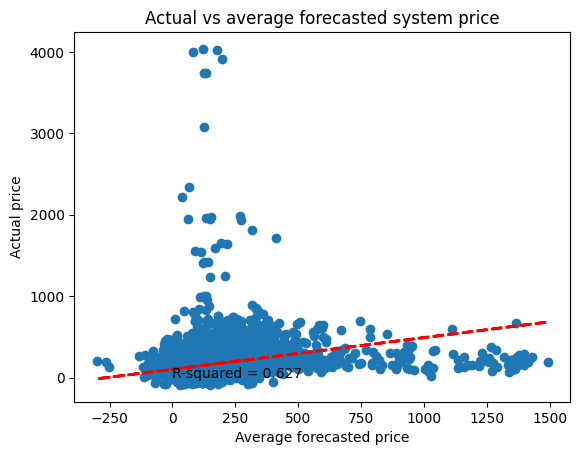

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy.stats


x = auction_data_df['forecast_system_average']
y = auction_data_df['system_price']
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg = 1 means linear fit (i.e. polynomial of degree 1)
a, b = np.polyfit(x, y, deg = 1)
plt.scatter(x, y);
# add line of best fit to plot
plt.plot(x, a*x+b, color='red', linestyle='--', linewidth=2)
plt.title('Actual vs average forecasted system price');
plt.xlabel("Average forecasted price")
plt.ylabel("Actual price")
plt.annotate("R-squared = {:.3f}".format(scipy.stats.spearmanr(x, y)[0]), (0, 0))
plt.show();

However, bare in mind that the `forecast_system_average` is not a solid predictor for the `system_price`.

# **2.2. Energy imbalance (system price)**

In [ ]:
energy_imbalance_df = auction_data_df.copy()

total_cost = 0
def energy_imbalance(row):
  global total_cost

  if row['price_forecast_first_auction'] >= row['price_forecast_second_auction']:
    upper_bound = row['price_forecast_second_auction'] + 5
    lower_bound = row['price_forecast_first_auction'] - 5

    # Buy second auction, sell the imbalance at system price
    if row['forecast_system_average'] > upper_bound and \
    row['price_forecast_second_auction'] >= row['price_second_auction']:
      row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
      row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
      total_cost += (20 * row['price_second_auction']) + 100
    # Sell first auction, buy the imbalance at system price
    elif row['forecast_system_average'] < lower_bound:
      # First auction bid accepted
      if row['price_forecast_first_auction'] <= row['price_first_auction']:
        row['planned_profit'] = (20 * row['price_forecast_first_auction']) - (20 * row['forecast_system_average']) - 100
        row['actual_profit'] = (20 * row['price_first_auction']) - (20 * row['system_price']) - 100
        total_cost += (20 * row['system_price']) + 100
      # First auction bid rejected
      else:
        # Second chance at second auction - buy second auction, sell the imbalance at system price
        if (row['forecast_system_average'] - row['price_forecast_second_auction'] > 5) and \
        row['price_forecast_second_auction'] >= row['price_second_auction']:
          row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
          row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
          total_cost += (20 * row['price_second_auction']) + 100
        # Second chance at second auction - sell second auction, buy the imbalance at system price
        elif (row['forecast_system_average'] - row['price_forecast_second_auction'] <- 5) and \
        row['price_forecast_second_auction'] <= row['price_second_auction']:
          row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
          row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
          total_cost += (20 * row['system_price']) + 100
        # No trading activity
        else:
          row["planned_profit"] = 0
          row["actual_profit"] = 0
    # No trading activity
    else:
      row["planned_profit"] = 0
      row["actual_profit"] = 0

  else:
    upper_bound = row['price_forecast_first_auction'] + 5
    lower_bound = row['price_forecast_second_auction'] - 5

    # Buy first auction, sell the imbalance at system price
    if row['forecast_system_average'] > upper_bound:
      # First auction bid accepted
      if row['price_forecast_first_auction'] >= row['price_first_auction']:
        row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_first_auction']) - 100
        row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_first_auction']) - 100
        total_cost += (20 * row['price_first_auction']) + 100
      # First auction bid rejected
      else:
        # Second chance at second auction - buy second auction, sell the imbalance at system price
        if (row['forecast_system_average'] - row['price_forecast_second_auction'] > 5) and \
        row['price_forecast_second_auction'] >= row['price_second_auction']:
          row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
          row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
          total_cost += (20 * row['price_second_auction']) + 100
        # Second chance at second auction - sell second auction, buy the imbalance at system price
        elif (row['forecast_system_average'] - row['price_forecast_second_auction'] < -5) and \
        row['price_forecast_second_auction'] <= row['price_second_auction']:
          row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
          row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
          total_cost += (20 * row['system_price']) + 100
        # No trading activity
        else:
          row["planned_profit"] = 0
          row["actual_profit"] = 0
    # Sell second auction, buy the imbalance at system price
    elif row['forecast_system_average'] < lower_bound and \
    row['price_forecast_second_auction'] <= row['price_second_auction']:
      row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
      row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
      total_cost += (20 * row['system_price']) + 100
    # No trading activity
    else:
      row["planned_profit"] = 0
      row["actual_profit"] = 0

  return row

energy_imbalance_df = energy_imbalance_df.apply(energy_imbalance, axis = 1)
energy_imbalance_df.head(20)

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price,price_forecast_difference,forecast_system_average,forecast_system_lower_quartile,forecast_system_upper_quartile,price_auction_difference,planned_profit,actual_profit
0,2021-01-01 00:00:00,68.00,65.73,2923.7,5102.4,54.19,64.840077,48.33,44.89,73.15,10.650077,46.610,23.3050,69.9150,-2.27,264.601547,-248.4
1,2021-01-01 01:00:00,62.70,64.96,2825.0,4771.5,53.42,60.886404,54.35,53.26,71.95,7.466404,53.805,26.9025,80.7075,2.26,41.628078,-239.8
2,2021-01-01 02:00:00,56.00,60.47,2611.4,4176.2,50.13,52.266738,32.66,65.86,54.56,2.136738,49.260,24.6300,73.8900,4.47,0.000000,0.0
3,2021-01-01 03:00:00,50.10,52.50,2669.3,3755.9,50.28,49.277567,41.55,63.43,70.73,-1.002433,52.490,26.2450,78.7350,2.40,0.000000,0.0
4,2021-01-01 04:00:00,50.00,48.98,2741.4,4047.5,47.19,46.268518,26.62,66.91,54.98,-0.921482,46.765,23.3825,70.1475,-1.02,0.000000,0.0
5,2021-01-01 05:00:00,48.00,48.95,2791.1,4172.7,42.15,47.484789,17.47,64.38,39.00,5.334789,40.925,20.4625,61.3875,0.95,31.195780,99.0
6,2021-01-01 06:00:00,50.00,48.96,2817.8,3977.3,51.04,52.794081,25.62,67.55,43.64,1.754081,46.585,23.2925,69.8775,-1.04,0.000000,0.0
7,2021-01-01 07:00:00,40.00,52.02,3938.3,9598.4,38.79,50.922166,26.96,67.24,29.01,12.132166,47.100,23.5500,70.6500,12.02,0.000000,0.0
8,2021-01-01 08:00:00,45.90,51.05,3854.2,8562.6,44.03,56.193145,46.78,47.17,17.54,12.163145,46.975,23.4875,70.4625,5.15,0.000000,0.0
9,2021-01-01 09:00:00,56.35,55.47,3610.7,7714.6,55.16,63.678233,39.38,87.23,49.73,8.518233,63.305,31.6525,94.9575,-0.88,0.000000,0.0


In [ ]:
print(f"Total cost: {round(total_cost, 2)}")
print(f"Total profit: {round(energy_imbalance_df['actual_profit'].sum(), 2)}")
print(f"Planned profit per trade: £{round(energy_imbalance_df['planned_profit'].sum()/len(energy_imbalance_df), 2)}")
print(f"Actual profit per trade: £{round(energy_imbalance_df['actual_profit'].sum()/len(energy_imbalance_df), 2)}")
print(f"Rate of return: {round((energy_imbalance_df['actual_profit'].sum()/total_cost) * 100, 2)}%")
print(f"Percentage of non-trading activity: {round((len(energy_imbalance_df.loc[(energy_imbalance_df['planned_profit'] == 0) & (energy_imbalance_df['actual_profit'] == 0)])) * 100/len(energy_imbalance_df), 2)}%")

Total cost: 20635556.9
Total profit: 1465992.9
Planned profit per trade: £467.96
Actual profit per trade: £98.53
Rate of return: 7.1%
Percentage of non-trading activity: 63.66%


Instead of having a bound of +/- 5, let's increase the number to 15 and see if it help us increase the rate of return.

In [ ]:
energy_imbalance_variant_df = auction_data_df.copy()

total_cost = 0
def energy_imbalance_variant(row):
  global total_cost

  if row['price_forecast_first_auction'] >= row['price_forecast_second_auction']:
    upper_bound = row['price_forecast_second_auction'] + 15
    lower_bound = row['price_forecast_first_auction'] - 15

    # Buy second auction, sell the imbalance at system price
    if row['forecast_system_average'] > upper_bound and \
    row['price_forecast_second_auction'] >= row['price_second_auction']:
      row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
      row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
      total_cost += (20 * row['price_second_auction']) + 100
    # Sell first auction, buy the imbalance at system price
    elif row['forecast_system_average'] < lower_bound:
      # First auction bid accepted
      if row['price_forecast_first_auction'] <= row['price_first_auction']:
        row['planned_profit'] = (20 * row['price_forecast_first_auction']) - (20 * row['forecast_system_average']) - 100
        row['actual_profit'] = (20 * row['price_first_auction']) - (20 * row['system_price']) - 100
        total_cost += (20 * row['system_price']) + 100
      # First auction bid rejected
      else:
        # Second chance at second auction - buy second auction, sell the imbalance at system price
        if (row['forecast_system_average'] - row['price_forecast_second_auction'] > 15) and \
        row['price_forecast_second_auction'] >= row['price_second_auction']:
          row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
          row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
          total_cost += (20 * row['price_second_auction']) + 100
        # Second chance at second auction - sell second auction, buy the imbalance at system price
        elif (row['forecast_system_average'] - row['price_forecast_second_auction'] < -15) and \
        row['price_forecast_second_auction'] <= row['price_second_auction']:
          row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
          row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
          total_cost += (20 * row['system_price']) + 100
        # No trading activity
        else:
          row["planned_profit"] = 0
          row["actual_profit"] = 0
    # No trading activity
    else:
      row["planned_profit"] = 0
      row["actual_profit"] = 0

  else:
    upper_bound = row['price_forecast_first_auction'] + 15
    lower_bound = row['price_forecast_second_auction'] - 15

    # Buy first auction, sell the imbalance at system price
    if row['forecast_system_average'] > upper_bound:
      # First auction bid accepted
      if row['price_forecast_first_auction'] >= row['price_first_auction']:
        row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_first_auction']) - 100
        row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_first_auction']) - 100
        total_cost += (20 * row['price_first_auction']) + 100
      # First auction bid rejected
      else:
        # Second chance at second auction - buy second auction, sell the imbalance at system price
        if (row['forecast_system_average'] - row['price_forecast_second_auction'] > 15) and \
        row['price_forecast_second_auction'] >= row['price_second_auction']:
          row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
          row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
          total_cost += (20 * row['price_second_auction']) + 100
        # Second chance at second auction - sell second auction, buy the imbalance at system price
        elif (row['forecast_system_average'] - row['price_forecast_second_auction'] < -15) and \
        row['price_forecast_second_auction'] <= row['price_second_auction']:
          row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
          row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
          total_cost += (20 * row['system_price']) + 100
        # No trading activity
        else:
          row["planned_profit"] = 0
          row["actual_profit"] = 0
    # Sell second auction, buy the imbalance at system price
    elif row['forecast_system_average'] < lower_bound and \
    row['price_forecast_second_auction'] <= row['price_second_auction']:
      row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
      row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
      total_cost += (20 * row['system_price']) + 100
    # No trading activity
    else:
      row["planned_profit"] = 0
      row["actual_profit"] = 0

  return row

energy_imbalance_variant_df = energy_imbalance_variant_df.apply(energy_imbalance_variant, axis = 1)
energy_imbalance_variant_df.head(20)

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price,price_forecast_difference,forecast_system_average,forecast_system_lower_quartile,forecast_system_upper_quartile,price_auction_difference,planned_profit,actual_profit
0,2021-01-01 00:00:00,68.00,65.73,2923.7,5102.4,54.19,64.840077,48.33,44.89,73.15,10.650077,46.610,23.3050,69.9150,-2.27,264.601547,-248.4
1,2021-01-01 01:00:00,62.70,64.96,2825.0,4771.5,53.42,60.886404,54.35,53.26,71.95,7.466404,53.805,26.9025,80.7075,2.26,0.000000,0.0
2,2021-01-01 02:00:00,56.00,60.47,2611.4,4176.2,50.13,52.266738,32.66,65.86,54.56,2.136738,49.260,24.6300,73.8900,4.47,0.000000,0.0
3,2021-01-01 03:00:00,50.10,52.50,2669.3,3755.9,50.28,49.277567,41.55,63.43,70.73,-1.002433,52.490,26.2450,78.7350,2.40,0.000000,0.0
4,2021-01-01 04:00:00,50.00,48.98,2741.4,4047.5,47.19,46.268518,26.62,66.91,54.98,-0.921482,46.765,23.3825,70.1475,-1.02,0.000000,0.0
5,2021-01-01 05:00:00,48.00,48.95,2791.1,4172.7,42.15,47.484789,17.47,64.38,39.00,5.334789,40.925,20.4625,61.3875,0.95,0.000000,0.0
6,2021-01-01 06:00:00,50.00,48.96,2817.8,3977.3,51.04,52.794081,25.62,67.55,43.64,1.754081,46.585,23.2925,69.8775,-1.04,0.000000,0.0
7,2021-01-01 07:00:00,40.00,52.02,3938.3,9598.4,38.79,50.922166,26.96,67.24,29.01,12.132166,47.100,23.5500,70.6500,12.02,0.000000,0.0
8,2021-01-01 08:00:00,45.90,51.05,3854.2,8562.6,44.03,56.193145,46.78,47.17,17.54,12.163145,46.975,23.4875,70.4625,5.15,0.000000,0.0
9,2021-01-01 09:00:00,56.35,55.47,3610.7,7714.6,55.16,63.678233,39.38,87.23,49.73,8.518233,63.305,31.6525,94.9575,-0.88,0.000000,0.0


In [ ]:
print(f"Total cost: {round(total_cost, 2)}")
print(f"Total profit: {round(energy_imbalance_variant_df['actual_profit'].sum(), 2)}")
print(f"Planned profit per trade: £{round(energy_imbalance_variant_df['planned_profit'].sum()/len(energy_imbalance_variant_df), 2)}")
print(f"Actual profit per trade: £{round(energy_imbalance_variant_df['actual_profit'].sum()/len(energy_imbalance_variant_df), 2)}")
print(f"Rate of return: {round((energy_imbalance_variant_df['actual_profit'].sum()/total_cost) * 100, 2)}%")
print(f"Percentage of non-trading activity: {round((len(energy_imbalance_variant_df.loc[(energy_imbalance_variant_df['planned_profit'] == 0) & (energy_imbalance_variant_df['actual_profit'] == 0)])) * 100/len(energy_imbalance_variant_df), 2)}%")

Total cost: 17540206.0
Total profit: 1485242.8
Planned profit per trade: £459.72
Actual profit per trade: £99.82
Rate of return: 8.47%
Percentage of non-trading activity: 72.89%


We can see the rate of return increase, but so is the percentage of non-trading activity. However, that should not be a concern as we have increase both the rate of return and the absolute profit (give a lower cost).

### **Determine optimal bound**

Now, let's increment our bound to determine at what bound do we achieve the highest rate of return.

In [ ]:
difference_list = []
roi_list = []
total_profit_list = []
non_trading_list = []

# Initialize the difference
difference = 5

while difference <= 75:
  energy_imbalance_iterate_df = auction_data_df.copy()

  total_cost = 0
  def energy_imbalance_iterate(row):
    global total_cost

    if row['price_forecast_first_auction'] >= row['price_forecast_second_auction']:
      upper_bound = row['price_forecast_second_auction'] + difference
      lower_bound = row['price_forecast_first_auction'] - difference

      # Buy second auction, sell the imbalance at system price
      if row['forecast_system_average'] > upper_bound and \
      row['price_forecast_second_auction'] >= row['price_second_auction']:
        row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
        row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
        total_cost += (20 * row['price_second_auction']) + 100
      # Sell first auction, buy the imbalance at system price
      elif row['forecast_system_average'] < lower_bound:
        # First auction bid accepted
        if row['price_forecast_first_auction'] <= row['price_first_auction']:
          row['planned_profit'] = (20 * row['price_forecast_first_auction']) - (20 * row['forecast_system_average']) - 100
          row['actual_profit'] = (20 * row['price_first_auction']) - (20 * row['system_price']) - 100
          total_cost += (20 * row['system_price']) + 100
        # First auction bid rejected
        else:
          # Second chance at second auction - buy second auction, sell the imbalance at system price
          if (row['forecast_system_average'] - row['price_forecast_second_auction'] > difference) and \
          row['price_forecast_second_auction'] >= row['price_second_auction']:
            row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
            row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
            total_cost += (20 * row['price_second_auction']) + 100
          # Second chance at second auction - sell second auction, buy the imbalance at system price
          elif (row['forecast_system_average'] - row['price_forecast_second_auction'] < -difference) and \
          row['price_forecast_second_auction'] <= row['price_second_auction']:
            row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
            row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
            total_cost += (20 * row['system_price']) + 100
          # No trading activity
          else:
            row["planned_profit"] = 0
            row["actual_profit"] = 0
      # No trading activity
      else:
        row["planned_profit"] = 0
        row["actual_profit"] = 0

    else:
      upper_bound = row['price_forecast_first_auction'] + difference
      lower_bound = row['price_forecast_second_auction'] - difference

      # Buy first auction, sell the imbalance at system price
      if row['forecast_system_average'] > upper_bound:
        # First auction bid accepted
        if row['price_forecast_first_auction'] >= row['price_first_auction']:
          row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_first_auction']) - 100
          row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_first_auction']) - 100
          total_cost += (20 * row['price_first_auction']) + 100
        # First auction bid rejected
        else:
          # Second chance at second auction - buy second auction, sell the imbalance at system price
          if (row['forecast_system_average'] - row['price_forecast_second_auction'] > difference) and \
          row['price_forecast_second_auction'] >= row['price_second_auction']:
            row['planned_profit'] = (20 * row['forecast_system_average']) - (20 * row['price_forecast_second_auction']) - 100
            row['actual_profit'] = (20 * row['system_price']) - (20 * row['price_second_auction']) - 100
            total_cost += (20 * row['price_second_auction']) + 100
          # Second chance at second auction - sell second auction, buy the imbalance at system price
          elif (row['forecast_system_average'] - row['price_forecast_second_auction'] < -difference) and \
          row['price_forecast_second_auction'] <= row['price_second_auction']:
            row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
            row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
            total_cost += (20 * row['system_price']) + 100
          # No trading activity
          else:
            row["planned_profit"] = 0
            row["actual_profit"] = 0
      # Sell second auction, buy the imbalance at system price
      elif row['forecast_system_average'] < lower_bound and \
      row['price_forecast_second_auction'] <= row['price_second_auction']:
        row['planned_profit'] = (20 * row['price_forecast_second_auction']) - (20 * row['forecast_system_average']) - 100
        row['actual_profit'] = (20 * row['price_second_auction']) - (20 * row['system_price']) - 100
        total_cost += (20 * row['system_price']) + 100
      # No trading activity
      else:
        row["planned_profit"] = 0
        row["actual_profit"] = 0

    return row

  energy_imbalance_iterate_df = energy_imbalance_iterate_df.apply(energy_imbalance_iterate, axis = 1)

  roi = energy_imbalance_iterate_df['actual_profit'].sum()/total_cost * 100
  non_trading = len(energy_imbalance_iterate_df.loc[(energy_imbalance_iterate_df['planned_profit'] == 0) & (energy_imbalance_iterate_df['actual_profit'] == 0)]) * 100/len(energy_imbalance_iterate_df)
  total_profit = energy_imbalance_iterate_df['actual_profit'].sum()

  difference_list.append(difference)
  roi_list.append(roi)
  non_trading_list.append(non_trading)
  total_profit_list.append(total_profit)

  # Increase the difference
  difference += 1

In [ ]:
difference_iterate_df = pd.DataFrame()

difference_iterate_df["bound"] = difference_list
difference_iterate_df["roi"] = roi_list
difference_iterate_df["non-trading_activity"] = non_trading_list
difference_iterate_df["total_profit"] = [i for i in total_profit_list]

difference_iterate_df

,bound,roi,non-trading_activity,total_profit
0,5,7.104208,63.660192,1465992.9
1,6,7.301658,64.863230,1477496.4
2,7,7.549480,66.120035,1497243.0
3,8,7.634554,67.067679,1491898.0
4,9,7.876373,68.075812,1512909.8
...,...,...,...,...
66,71,14.696348,90.160629,1236706.8
67,72,14.752727,90.281605,1230688.8
68,73,14.729742,90.402581,1218345.8
69,74,14.620390,90.496673,1201229.0


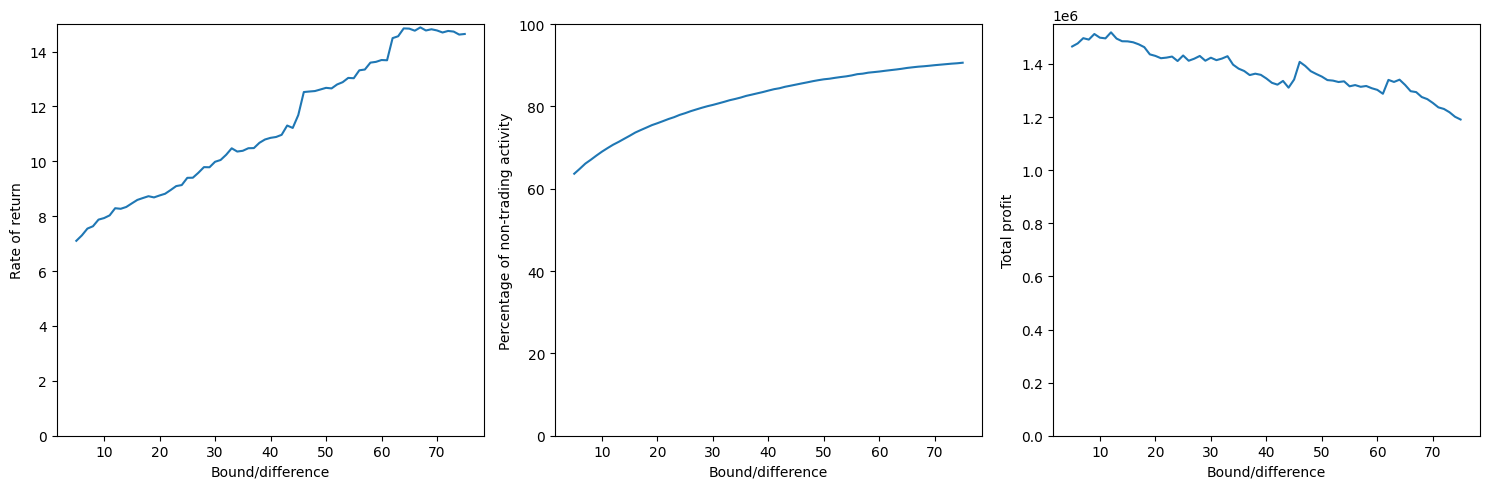

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].plot(difference_iterate_df["bound"], difference_iterate_df["roi"])
axes[0].set_ylim([0, 15])
axes[0].set_ylabel("Rate of return")
axes[0].set_xlabel("Bound/difference")

axes[1].plot(difference_iterate_df["bound"], difference_iterate_df["non-trading_activity"])
axes[1].set_ylim([0, 100])
axes[1].set_ylabel("Percentage of non-trading activity")
axes[1].set_xlabel("Bound/difference")

axes[2].plot(difference_iterate_df["bound"], difference_iterate_df["total_profit"])
axes[2].set_ylim([0, 1.55e6])
axes[2].set_ylabel("Total profit")
axes[2].set_xlabel("Bound/difference")

fig.tight_layout()

From the plotted graph, we can conclude that

1.   **Rate of return**: Our rate of return has increase steadily as our bound increase, but it level off at around 14.6% when the bound reach 65.
2.   **Non-trading activity**: As we expected, the higher the bound, the higher the percentage of non-trading activity. We can see, as we reach the end, we achieve a 90% non-trading activity. In other words, out of 24 bids per day, we would only execute 2.4 (so 2-3) bids on average, as we are being more selective and wanting to ensure the trade satisfy our bound
3.   **Total profit**: Overall, there's a decreasing pattern of the total profit, which is understandable as our percentage of non-trading activity has increased, we are making less money from less trade

Therefore, it's important to recognize the tradeoff and understand our priority - are we maximizing our rate of return or our total profit. If we have sufficient capital, we can increase the volume traded to generate more profit. On the other hand, if we limited capital, we would likely aim to maximize our rate of return.

